In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import copy
import os
import torch.nn.utils.prune as prune
import matplotlib.pyplot as plt
import time
from torchvision import datasets, models, transforms
from pathlib import Path
from typing import Any, cast, Dict, List, Optional, Union
import torchvision.transforms as transforms
import torch.optim as optim

from pprint import pprint

!rm data || rm -rf data
!mkdir data
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

torch.manual_seed(0)
np.random.seed(0)

rm: cannot remove 'data': No such file or directory
PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


Helper functions:

1. To get model size
2. To validate and produce accuracy for the model

In [2]:
def validate_model(model, dataloader, device = "cuda", trials = 1):

    model.eval()

    dev = torch.device(device)
    model.to(dev)

    run_time = 0
    correct = 0
    total = 0 


    if (device == "cuda"):


      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)

        #print(f"i = {i}")
        start = time.time()

        inputs = inputs.to(dev)
        labels = labels.to(dev)
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        torch.cuda.synchronize()
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        predicted = predicted.to("cpu")
        labels = labels.to("cpu")

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total

      torch.cuda.empty_cache()

    elif (device == "cpu"):
      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)totalzeros = 0
        totalelements = 0
        start = time.time()
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total


    return run_time, accuracy

def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    print("Model size: ", model_size)
    return model_size

Functions to reconstruct the smaller new VGG-19 models after pruning:

In [3]:
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_lin_layers(last_out_channels,num_hidden,num_classes) -> nn.Sequential:

    layers: List[nn.Module] = []
    layers += [nn.Linear(last_out_channels,num_hidden)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Dropout(p=0.5)]
    layers += [nn.Linear(num_hidden, num_hidden)]
    layers += [nn.ReLU(inplace=True)]
    layers += [nn.Dropout(p=0.5)]
    layers += [nn.Linear(num_hidden, num_classes)]

    return nn.Sequential(*layers)

Loading the pretrained model:

In [4]:
vgg_19_CIFAR_10_ver1 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg19_bn", pretrained = True)

/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg19_bn-57191229.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg19_bn-57191229.pt


  0%|          | 0.00/78.5M [00:00<?, ?B/s]

Function to plot the weight distribution layerwise before/after AFCLE:

In [58]:
def plot_weights_VGG19(model1,conv_list1, model2, conv_list2):
    
    for i in range(len(conv_list1)):  
        x1 = model1.features[conv_list1[i]].weight
        sh1 = model1.features[conv_list1[i]].weight.shape
        N1, C1, W1, H1 = sh1[0], sh1[1], sh1[2], sh1[3]
        y1 = x1.view(N1, C1 * W1 * H1)
        x1_new = y1.detach().cpu().numpy()

        x2 = model2.features[conv_list2[i]].weight
        sh2 = model2.features[conv_list2[i]].weight.shape
        N2, C2, W2, H2 = sh2[0], sh2[1], sh2[2], sh2[3]
        y2 = x2.view(N2, C2 * W2 * H2)
        x2_new = y2.detach().cpu().numpy()    

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle("CONV LAYER: "+str(i))
        fig.set_figwidth(35)
        fig.set_figheight(7)
        ax1.boxplot(x1_new.T,showfliers=False)
        ax2.boxplot(x2_new.T,showfliers=False) 
        fig.autofmt_xdate()
        plt.show()


Loading the datasets and dataloader:

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=True, num_workers=4)
                                
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
accu_list = []
size_model = []
sparse_list = []
runtime_list = []

Validating and recording stats (accuracy, runtime, model size) for original model:

In [8]:
rn_time, acc = validate_model(vgg_19_CIFAR_10_ver1, testloader,device="cuda")

model_sz = get_size_of_model(vgg_19_CIFAR_10_ver1)

accu_list.append(acc)
runtime_list.append(rn_time)
size_model.append(model_sz)
sparse_list.append(0)

[250] accuracy : 81.4000%
[500] accuracy : 82.1000%
[750] accuracy : 82.1000%
[1000] accuracy : 82.4250%
[1250] accuracy : 81.9600%
[1500] accuracy : 81.4000%
[1750] accuracy : 81.3000%
[2000] accuracy : 81.3625%
[2250] accuracy : 81.3000%
[2500] accuracy : 81.3100%
Model size:  82.338669


Function that prunes, reduces the model size and retrains the model:

In [9]:
def prune_compr(vgg_19_CIFAR_10, prune_rate_r, num_epochs, model_spars):
    
    conv2d = [0,3,7,10,14,17,20,23,27,30,33,36,40,43,46,49]   # List of conv2d layers numbers
    fc = [0,3,6] 

    convs_to_prune = (
        (vgg_19_CIFAR_10.features[0], 'weight'), # conv1 of VGG19
        (vgg_19_CIFAR_10.features[3], 'weight'), # conv2 of VGG19
        (vgg_19_CIFAR_10.features[7], 'weight'), # conv3 of VGG19
        (vgg_19_CIFAR_10.features[10], 'weight'), # conv4 of VGG19
        (vgg_19_CIFAR_10.features[14], 'weight'), # conv5 of VGG19
        (vgg_19_CIFAR_10.features[17], 'weight'), # conv6 of VGG19
        (vgg_19_CIFAR_10.features[20], 'weight'), # conv7 of VGG19
        (vgg_19_CIFAR_10.features[23], 'weight'), # conv8 of VGG19
        (vgg_19_CIFAR_10.features[27], 'weight'), # conv9 of VGG19
        (vgg_19_CIFAR_10.features[30], 'weight'), # conv10 of VGG19
        (vgg_19_CIFAR_10.features[33], 'weight'), # conv11 of VGG19
        (vgg_19_CIFAR_10.features[36], 'weight'), # conv12 of VGG19
        (vgg_19_CIFAR_10.features[40], 'weight'), # conv13 of VGG19 
        (vgg_19_CIFAR_10.features[43], 'weight'),# conv14 of VGG19 
        (vgg_19_CIFAR_10.features[46], 'weight'), # conv15 of VGG19 
        (vgg_19_CIFAR_10.features[49], 'weight') # conv16 of VGG19 
    )
    #TODO: Add linear layers to prune
    linears_to_prune = (
        (vgg_19_CIFAR_10.classifier[0], 'weight'), # fc1 of VGG19
        (vgg_19_CIFAR_10.classifier[3], 'weight') # f2c of VGG19
    )

    # prune along output
    dimen = 0 
    num_classes = 10

      #TODO: Prune model
    for param, name in convs_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate_r/100, n=2, dim=dimen)
    for param, name in linears_to_prune:
        prune.ln_structured(param, name=name, amount=prune_rate_r/100, n=2, dim=dimen)

    for param, name in convs_to_prune:
        prune.remove(param, name)
    for param, name in linears_to_prune:
        prune.remove(param, name)


    # rn_time, acc = validate_model(vgg_19_CIFAR_10, testloader,device="cuda")

    print("\n\n===============================\nMODEL SIZE WITHOUT COMPRESSION\n===============================\n\n")
    model_sz = get_size_of_model(vgg_19_CIFAR_10)

    # accu_list.append(acc)
    # runtime_list.append(rn_time)
    size_model.append(model_sz)
    # sparse_list.append(model_spars)


    vgg_19_CIFAR_10_new = copy.deepcopy(vgg_19_CIFAR_10)
    outputs = []                                # List of num of output channels in conv layers
    main_ind = []                               # List of non-zero indexes for conv layers
    make_layer_len = []                         # new conv model config

    # getting num of output channels
    for i in conv2d:
        #print(vgg_19_CIFAR_10.features[i].weight.size()[0])
        outputs.append(vgg_19_CIFAR_10.features[i].weight.size()[0]) #pruning along outputs(dim=0)

    #getting non-zero output channel indexes for conv layers
    for i in range(len(conv2d)):
        non_zero_layer = []                     # List of non-zero indexes for each conv layer
        for y in range(outputs[i]):
            sub_mod = vgg_19_CIFAR_10.features[conv2d[i]].weight[y,:,:,:]
            sub_mod_cloned = sub_mod.clone()
            if(torch.nonzero(sub_mod_cloned).size()[0]!=0):
                non_zero_layer.append(y)

        main_ind.append(non_zero_layer)
        
        #constructing new model config
        if (conv2d[i]==3 or conv2d[i]==10 or conv2d[i]==23 or conv2d[i]==36 or conv2d[i]==49):
            #print(len(non_zero_layer))
            make_layer_len.append(len(non_zero_layer))
            make_layer_len.append("M")
        else:
            #print(len(non_zero_layer))
            make_layer_len.append(len(non_zero_layer))   

    #constructing new features for new model
    tmp_conv_model = make_layers(make_layer_len,batch_norm = True)
    vgg_19_CIFAR_10_new.features = tmp_conv_model

    #storing pruned weights in new conv model
    for i in range(len(main_ind)):
        
        # removing only output channels for first layer
        if (conv2d[i]==0):
            indices_out = torch.tensor(main_ind[i])
            indices_out = indices_out.to("cuda")
            
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].weight, 0, indices_out)
            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].bias, 0, indices_out)
            
            new_sub_batch_norm_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].weight, 0, indices_out)
            new_sub_batch_norm_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].bias, 0, indices_out)

        # removing input and output channels    
        else:
            indices_out = torch.tensor(main_ind[i])
            indices_out = indices_out.to("cuda")
            
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].weight, 0, indices_out)
            
            new_sub_batch_norm_mod = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].weight, 0, indices_out)
           
            indices_in = torch.tensor(main_ind[i-1])
            indices_in = indices_in.to("cuda")
            
            new_sub_mod = torch.index_select(new_sub_mod, 1, indices_in)
            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]].bias, 0, indices_out)

            new_sub_batch_norm_bias = torch.index_select(vgg_19_CIFAR_10.features[conv2d[i]+1].bias, 0, indices_out)

                  
        #assigning the non-zero weights
        vgg_19_CIFAR_10_new.features[conv2d[i]].weight =  torch.nn.Parameter(new_sub_mod)
        vgg_19_CIFAR_10_new.features[conv2d[i]].bias =  torch.nn.Parameter(new_sub_bias)
        vgg_19_CIFAR_10_new.features[conv2d[i]+1].weight =  torch.nn.Parameter(new_sub_batch_norm_mod)
        vgg_19_CIFAR_10_new.features[conv2d[i]+1].bias =  torch.nn.Parameter(new_sub_batch_norm_bias)
        
    main_ind_linear_out = []                               # List of non-zero indexes for linear layers
    make_layer_len_linear_out = []                         # new linear model config

    # getting non-zero output channel indexes for linear layers
    for i in range(len(fc)):
        if (fc[i]==0 or fc[i]==3):                          # omit last layer for output pruning
            non_zero_layer = []                             # List of non-zero indexes for each layer
            for y in range(vgg_19_CIFAR_10.classifier[fc[i]].weight.size()[0]):
                sub_mod = vgg_19_CIFAR_10.classifier[fc[i]].weight[y][:]
                if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):
                    non_zero_layer.append(y)
            
            main_ind_linear_out.append(non_zero_layer)  
            make_layer_len_linear_out.append(len(non_zero_layer)) 

            
    #constructing new classifier for new model
    tmp_lin_model = make_lin_layers(len(main_ind[15]),len(main_ind[15]),num_classes) 
    vgg_19_CIFAR_10_new.classifier = tmp_lin_model
    
    #storing pruned weights in new lin model
    for i in range(len(fc)):
        
        # removing output channels for first layer and input channel wrt conv output
        if (fc[i]==0):
            indices_out = torch.tensor(main_ind_linear_out[i])
            indices_out = indices_out.to("cuda")
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].weight, 0, indices_out)

            out_ind_last_conv =  main_ind[15]

            indices_in = torch.tensor(out_ind_last_conv)
            indices_in = indices_in.to("cuda")
            new_sub_mod = torch.index_select(new_sub_mod, 1, indices_in)

            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].bias, 0, indices_out)
        
        #removing input and output channels    
        elif(fc[i]==3):
            indices_out = torch.tensor(main_ind_linear_out[i])
            indices_out = indices_out.to("cuda")
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].weight, 0, indices_out)
            
            indices_in = torch.tensor(main_ind_linear_out[i-1])
            indices_in = indices_in.to("cuda")
            new_sub_mod = torch.index_select(new_sub_mod, 1, indices_in)

            new_sub_bias = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].bias, 0, indices_out)

        # removing only input channels    
        elif(fc[i]==6):
            indices_in = torch.tensor(main_ind_linear_out[i-1])
            indices_in = indices_in.to("cuda")
            new_sub_mod = torch.index_select(vgg_19_CIFAR_10.classifier[fc[i]].weight, 1, indices_in)
            
            new_sub_bias = vgg_19_CIFAR_10.classifier[fc[i]].bias

        #assigning the non-zero weights
        vgg_19_CIFAR_10_new.classifier[fc[i]].weight =  torch.nn.Parameter(new_sub_mod)
        vgg_19_CIFAR_10_new.classifier[fc[i]].bias =  torch.nn.Parameter(new_sub_bias)

    print("\n\n===============================\nPRUNED MODEL ACCURACY\n===============================\n\n")
    rn_time, acc = validate_model(vgg_19_CIFAR_10_new, testloader,device="cuda")

    print("\n\n===============================\nMODEL SIZE WITH COMPRESSION\n===============================\n\n")
    model_sz = get_size_of_model(vgg_19_CIFAR_10_new)

    accu_list.append(acc)
    runtime_list.append(rn_time)
    size_model.append(model_sz)
    sparse_list.append(model_spars)

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Batch size changed from 4 to 64 as in the paper.
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=False, num_workers=2)
                                    
    classes = ('plane', 'car', 'bird', 'cat',
              'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    criterion = nn.CrossEntropyLoss() # TODO create criterion
    optimizer = optim.SGD(vgg_19_CIFAR_10_new.parameters(), lr = 0.01, momentum=0.9, weight_decay=0.0001) 

    print("\n\n===============================\nTraining model\n===============================\n")
    for epoch in range(num_epochs):
            running_loss = 0.0
            # this allows us to get an index from a foreach loop
            vgg_19_CIFAR_10_new.train()
            dev = torch.device("cuda")
            vgg_19_CIFAR_10_new.to(dev)
            for i, data in enumerate(trainloader, 0):
                # data is a list of [inputs, labels]
                inputs, labels = data
                
                inputs = inputs.to(dev)
                labels = labels.to(dev)  
                # Zero parameter gradients
                optimizer.zero_grad()

                # Go forward, backward then optimize
                outputs = vgg_19_CIFAR_10_new(inputs)   # forward
                loss = criterion(outputs, labels)   # calculate loss
                loss.backward()         # backward
                
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % (100) == (100) - 1:
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {(running_loss):.8f}')
                    running_loss = 0.0

    print("\n\n===============================\nRETRAINED MODEL ACCURACY\n===============================\n\n")
    rn_time, acc = validate_model(vgg_19_CIFAR_10_new, testloader,device="cuda")

    accu_list.append(acc)
    runtime_list.append(rn_time)
    sparse_list.append(model_spars)

    return vgg_19_CIFAR_10_new

Iterative pruning and retraining:

In [10]:
prune_rate = 20
model_sparse_full = 100
num_of_epchs = 4

print("===============================\nSPARSITY\n===============================")
sprs = (prune_rate/100)*model_sparse_full 
print("first prune: ",sprs)
vgg_19_CIFAR_10_ver2 = prune_compr(vgg_19_CIFAR_10_ver1, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY
first prune:  20.0


MODEL SIZE WITHOUT COMPRESSION


Model size:  82.338669


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 10.0000%
[500] accuracy : 10.5500%
[750] accuracy : 10.8333%
[1000] accuracy : 10.4500%
[1250] accuracy : 10.2200%
[1500] accuracy : 10.0667%
[1750] accuracy : 10.0571%
[2000] accuracy : 9.9875%
[2250] accuracy : 10.0111%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  52.826477
Files already downloaded and verified


Training model

[1,   100] loss: 89.69362688
[1,   200] loss: 61.86028156
[1,   300] loss: 50.79209468
[1,   400] loss: 48.11314201
[1,   500] loss: 42.83233020
[1,   600] loss: 43.72513473
[1,   700] loss: 41.19649504
[2,   100] loss: 37.42985047
[2,   200] loss: 29.60469709
[2,   300] loss: 28.98887040
[2,   400] loss: 28.83655221
[2,   500] loss: 26.44696153
[2,   600] loss: 27.64385278
[2,   700] loss: 25.09790932
[3,   100] loss: 21.23229028
[3,   200] loss: 23.09769084
[3,   300] loss: 21.77182879
[3,   400] loss: 18.45543266
[3,   500] loss: 19.80357059
[3,   600] loss: 19.26503826
[3,   700] loss: 18.02589210
[4,   100] los

In [11]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nsecond prune: ",sprs)
vgg_19_CIFAR_10_ver3 = prune_compr(vgg_19_CIFAR_10_ver2, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

second prune:  36.0


MODEL SIZE WITHOUT COMPRESSION


Model size:  52.826477


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.0000%
[500] accuracy : 9.2000%
[750] accuracy : 9.4000%
[1000] accuracy : 9.9000%
[1250] accuracy : 9.8600%
[1500] accuracy : 9.9333%
[1750] accuracy : 9.9714%
[2000] accuracy : 10.0875%
[2250] accuracy : 10.0889%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  33.846253
Files already downloaded and verified


Training model

[1,   100] loss: 35.49922372
[1,   200] loss: 26.48579491
[1,   300] loss: 24.33970704
[1,   400] loss: 26.01450417
[1,   500] loss: 26.23158144
[1,   600] loss: 24.63821313
[1,   700] loss: 22.08864983
[2,   100] loss: 16.88381343
[2,   200] loss: 17.26245404
[2,   300] loss: 18.83523071
[2,   400] loss: 18.43722651
[2,   500] loss: 15.71790573
[2,   600] loss: 20.06448118
[2,   700] loss: 19.00674591
[3,   100] loss: 15.11202860
[3,   200] loss: 13.67035068
[3,   300] loss: 15.62829766
[3,   400] loss: 12.52724626
[3,   500] loss: 12.30124149
[3,   600] loss: 12.67936885
[3,   700] loss: 11.24970996
[4,   100] loss: 12.

In [12]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nthird prune: ",sprs)
vgg_19_CIFAR_10_ver4 = prune_compr(vgg_19_CIFAR_10_ver3, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

third prune:  48.8


MODEL SIZE WITHOUT COMPRESSION


Model size:  33.846253


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.3000%
[500] accuracy : 9.4000%
[750] accuracy : 9.3333%
[1000] accuracy : 9.8500%
[1250] accuracy : 9.9600%
[1500] accuracy : 10.0000%
[1750] accuracy : 10.3857%
[2000] accuracy : 10.2000%
[2250] accuracy : 10.0000%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  21.630701
Files already downloaded and verified


Training model

[1,   100] loss: 32.85225645
[1,   200] loss: 25.64318282
[1,   300] loss: 27.11356073
[1,   400] loss: 24.82305469
[1,   500] loss: 25.84491151
[1,   600] loss: 22.79391100
[1,   700] loss: 21.03939930
[2,   100] loss: 18.94301613
[2,   200] loss: 18.45370046
[2,   300] loss: 16.77098943
[2,   400] loss: 18.10993797
[2,   500] loss: 17.07838098
[2,   600] loss: 16.87937192
[2,   700] loss: 16.25645058
[3,   100] loss: 12.64696115
[3,   200] loss: 14.39812819
[3,   300] loss: 15.22428405
[3,   400] loss: 14.73020441
[3,   500] loss: 11.93891757
[3,   600] loss: 13.56502958
[3,   700] loss: 13.88426637
[4,   100] loss: 1

In [13]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nfourth prune: ",sprs)
vgg_19_CIFAR_10_ver5 = prune_compr(vgg_19_CIFAR_10_ver4, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

fourth prune:  59.04


MODEL SIZE WITHOUT COMPRESSION


Model size:  21.630701


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 8.7000%
[500] accuracy : 8.1000%
[750] accuracy : 9.1333%
[1000] accuracy : 9.5750%
[1250] accuracy : 9.8600%
[1500] accuracy : 9.9667%
[1750] accuracy : 9.9000%
[2000] accuracy : 10.0000%
[2250] accuracy : 10.0333%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  13.919597
Files already downloaded and verified


Training model

[1,   100] loss: 39.61489885
[1,   200] loss: 32.83246937
[1,   300] loss: 31.77844465
[1,   400] loss: 29.69067625
[1,   500] loss: 29.07172584
[1,   600] loss: 28.30793676
[1,   700] loss: 26.73847613
[2,   100] loss: 23.47709204
[2,   200] loss: 22.89998098
[2,   300] loss: 21.31067839
[2,   400] loss: 21.12275262
[2,   500] loss: 19.36391437
[2,   600] loss: 20.84564712
[2,   700] loss: 20.15403409
[3,   100] loss: 16.03722217
[3,   200] loss: 16.10875951
[3,   300] loss: 17.11253732
[3,   400] loss: 17.10549434
[3,   500] loss: 15.52292478
[3,   600] loss: 15.29444490
[3,   700] loss: 16.32693775
[4,   100] loss: 13.

In [14]:
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nfifth prune: ",sprs)
vgg_19_CIFAR_10_ver6 = prune_compr(vgg_19_CIFAR_10_ver5, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

fifth prune:  67.232


MODEL SIZE WITHOUT COMPRESSION


Model size:  13.919597


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.4000%
[500] accuracy : 9.4500%
[750] accuracy : 9.7000%
[1000] accuracy : 9.6500%
[1250] accuracy : 9.9600%
[1500] accuracy : 10.0333%
[1750] accuracy : 9.9571%
[2000] accuracy : 10.0000%
[2250] accuracy : 9.8222%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  8.927341
Files already downloaded and verified


Training model

[1,   100] loss: 48.57244664
[1,   200] loss: 37.65986259
[1,   300] loss: 39.26676174
[1,   400] loss: 36.74057414
[1,   500] loss: 33.68282728
[1,   600] loss: 36.19592907
[1,   700] loss: 33.48254653
[2,   100] loss: 29.53867202
[2,   200] loss: 26.92508707
[2,   300] loss: 27.37452266
[2,   400] loss: 25.84704643
[2,   500] loss: 24.51491655
[2,   600] loss: 27.26988531
[2,   700] loss: 23.11435560
[3,   100] loss: 22.02362244
[3,   200] loss: 20.85446116
[3,   300] loss: 22.40115223
[3,   400] loss: 19.48032002
[3,   500] loss: 19.87700652
[3,   600] loss: 20.85177106
[3,   700] loss: 19.61555487
[4,   100] loss: 17.8

In [15]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nsixth prune: ",sprs)
vgg_19_CIFAR_10_ver7 = prune_compr(vgg_19_CIFAR_10_ver6, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

sixth prune:  70.5088


MODEL SIZE WITHOUT COMPRESSION


Model size:  8.927341


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 8.9000%
[500] accuracy : 10.3000%
[750] accuracy : 10.4000%
[1000] accuracy : 10.1750%
[1250] accuracy : 10.1200%
[1500] accuracy : 10.0667%
[1750] accuracy : 10.1857%
[2000] accuracy : 10.2000%
[2250] accuracy : 10.1556%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  7.236589
Files already downloaded and verified


Training model

[1,   100] loss: 33.00829410
[1,   200] loss: 29.07139166
[1,   300] loss: 27.31869097
[1,   400] loss: 26.22262164
[1,   500] loss: 27.20241223
[1,   600] loss: 28.73708573
[1,   700] loss: 23.89646026
[2,   100] loss: 21.08754328
[2,   200] loss: 20.60101914
[2,   300] loss: 21.11037422
[2,   400] loss: 21.20098602
[2,   500] loss: 21.01239785
[2,   600] loss: 21.14963196
[2,   700] loss: 20.26840801
[3,   100] loss: 18.88867817
[3,   200] loss: 18.99289345
[3,   300] loss: 19.22049487
[3,   400] loss: 16.84175247
[3,   500] loss: 17.66641382
[3,   600] loss: 20.81263297
[3,   700] loss: 15.84722964
[4,   100] loss

In [16]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nseventh prune: ",sprs)
vgg_19_CIFAR_10_ver8 = prune_compr(vgg_19_CIFAR_10_ver7, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

seventh prune:  73.45792


MODEL SIZE WITHOUT COMPRESSION


Model size:  7.236589


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.9000%
[500] accuracy : 10.1000%
[750] accuracy : 10.0333%
[1000] accuracy : 10.3000%
[1250] accuracy : 10.0800%
[1500] accuracy : 10.1000%
[1750] accuracy : 10.1286%
[2000] accuracy : 10.2000%
[2250] accuracy : 10.1222%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  5.869805
Files already downloaded and verified


Training model

[1,   100] loss: 33.55032393
[1,   200] loss: 32.77978314
[1,   300] loss: 29.19846236
[1,   400] loss: 31.19675634
[1,   500] loss: 29.00225468
[1,   600] loss: 28.39598364
[1,   700] loss: 26.92133771
[2,   100] loss: 22.09994210
[2,   200] loss: 24.05646346
[2,   300] loss: 22.05471724
[2,   400] loss: 22.70362711
[2,   500] loss: 23.48626670
[2,   600] loss: 24.26819412
[2,   700] loss: 20.80066851
[3,   100] loss: 18.07683191
[3,   200] loss: 18.35727716
[3,   300] loss: 20.24639573
[3,   400] loss: 18.12036305
[3,   500] loss: 18.23149370
[3,   600] loss: 20.36481190
[3,   700] loss: 18.66780002
[4,   100] loss

In [17]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\neigth prune: ",sprs)
vgg_19_CIFAR_10_ver9 = prune_compr(vgg_19_CIFAR_10_ver8, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

eigth prune:  76.112128


MODEL SIZE WITHOUT COMPRESSION


Model size:  5.869805


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 9.9000%
[500] accuracy : 10.3000%
[750] accuracy : 10.1667%
[1000] accuracy : 10.0750%
[1250] accuracy : 10.0200%
[1500] accuracy : 10.1833%
[1750] accuracy : 10.2857%
[2000] accuracy : 10.2875%
[2250] accuracy : 10.1000%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  4.734253
Files already downloaded and verified


Training model

[1,   100] loss: 46.82433759
[1,   200] loss: 38.59874885
[1,   300] loss: 33.82612254
[1,   400] loss: 32.64496669
[1,   500] loss: 27.43194329
[1,   600] loss: 32.56688107
[1,   700] loss: 28.23212430
[2,   100] loss: 26.39803554
[2,   200] loss: 23.21637912
[2,   300] loss: 25.53179024
[2,   400] loss: 23.15908924
[2,   500] loss: 23.06625535
[2,   600] loss: 23.63039457
[2,   700] loss: 22.49639380
[3,   100] loss: 24.62187556
[3,   200] loss: 22.92313389
[3,   300] loss: 20.25540251
[3,   400] loss: 19.40967755
[3,   500] loss: 19.39288625
[3,   600] loss: 20.56057608
[3,   700] loss: 17.54142016
[4,   100] loss

In [18]:
prune_rate = 10
print("===============================\nSPARSITY\n===============================")
sprs += (prune_rate/100)*model_sparse_full 
print("\nninth prune: ",sprs)
vgg_19_CIFAR_10_ver10 = prune_compr(vgg_19_CIFAR_10_ver9, prune_rate, num_of_epchs, sprs)
model_sparse_full = 100 - sprs

SPARSITY

ninth prune:  78.5009152


MODEL SIZE WITHOUT COMPRESSION


Model size:  4.734253


PRUNED MODEL ACCURACY




<ipython-input-9-ea6f03a249b2>:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if(torch.nonzero(torch.tensor(sub_mod)).size()[0]!=0):


[250] accuracy : 10.6000%
[500] accuracy : 10.4000%
[750] accuracy : 10.9000%
[1000] accuracy : 10.8000%
[1250] accuracy : 10.6400%
[1500] accuracy : 10.6000%
[1750] accuracy : 10.3714%
[2000] accuracy : 10.2875%
[2250] accuracy : 10.0667%
[2500] accuracy : 10.0000%


MODEL SIZE WITH COMPRESSION


Model size:  3.856941
Files already downloaded and verified


Training model

[1,   100] loss: 44.01272736
[1,   200] loss: 40.59325019
[1,   300] loss: 38.75719854
[1,   400] loss: 38.10743712
[1,   500] loss: 32.45552742
[1,   600] loss: 36.95592828
[1,   700] loss: 33.09334110
[2,   100] loss: 28.79475332
[2,   200] loss: 29.64730176
[2,   300] loss: 26.66473656
[2,   400] loss: 28.28247073
[2,   500] loss: 25.77280036
[2,   600] loss: 27.07498476
[2,   700] loss: 26.91586334
[3,   100] loss: 25.16510999
[3,   200] loss: 25.34452195
[3,   300] loss: 22.32849612
[3,   400] loss: 23.88805360
[3,   500] loss: 21.85950133
[3,   600] loss: 24.78655616
[3,   700] loss: 24.41767597
[4,   100] los

In [19]:
new_accu_list = []
for ele in accu_list:
    new_accu_list.append(ele.item())

print(new_accu_list)
print(size_model)
print(sparse_list)
print(runtime_list)

print(len(new_accu_list))
print(len(size_model))
print(len(sparse_list))
print(len(runtime_list))

[81.31, 10.0, 87.46, 10.0, 87.7, 10.0, 87.28, 10.0, 85.26, 10.0, 83.47, 10.0, 84.74, 10.0, 82.59, 10.0, 82.05, 10.0, 81.56]
[82.338669, 82.338669, 52.826477, 52.826477, 33.846253, 33.846253, 21.630701, 21.630701, 13.919597, 13.919597, 8.927341, 8.927341, 7.236589, 7.236589, 5.869805, 5.869805, 4.734253, 4.734253, 3.856941]
[0, 20.0, 20.0, 36.0, 36.0, 48.8, 48.8, 59.04, 59.04, 67.232, 67.232, 70.5088, 70.5088, 73.45792, 73.45792, 76.112128, 76.112128, 78.5009152, 78.5009152]
[19.243625164031982, 12.009558916091919, 11.729831457138062, 11.510571956634521, 11.223005056381226, 11.03633451461792, 10.596876859664917, 10.66861891746521, 10.651603698730469, 10.3968026638031, 10.290465593338013, 10.60562801361084, 10.498385190963745, 10.45750117301941, 10.611282587051392, 10.473049640655518, 10.782381534576416, 10.703890085220337, 10.465423107147217]
19
19
19
19


In [20]:
new_sparselist = []
[new_sparselist.append(x) for x in sparse_list if x not in new_sparselist]

print(new_sparselist)
print(len(new_sparselist))

new_size_model = []
[new_size_model.append(x) for x in size_model if x not in new_size_model]

print(new_size_model)
print(len(new_size_model))
print()
 

[0, 20.0, 36.0, 48.8, 59.04, 67.232, 70.5088, 73.45792, 76.112128, 78.5009152]
10
[82.338669, 52.826477, 33.846253, 21.630701, 13.919597, 8.927341, 7.236589, 5.869805, 4.734253, 3.856941]
10



Plotting the results:

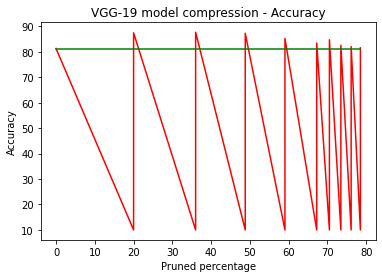

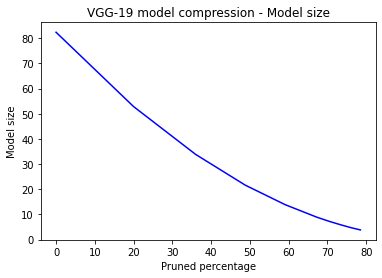

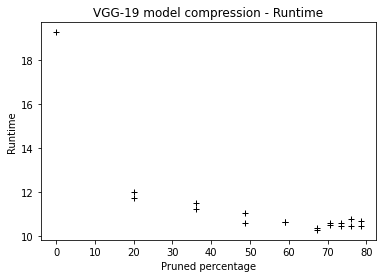

In [21]:
# importing the modules
import numpy as np
import matplotlib.pyplot as plt

baseline = np.ones(len(new_accu_list))*81.31

# plotting
plt.title("VGG-19 model compression - Accuracy")
plt.xlabel("Pruned percentage")
plt.ylabel("Accuracy")
plt.plot(sparse_list, new_accu_list, color ="red")
plt.plot(sparse_list, baseline, color ="green")
plt.show()

plt.title("VGG-19 model compression - Model size")
plt.xlabel("Pruned percentage")
plt.ylabel("Model size")
plt.plot(new_sparselist, new_size_model, color ="blue")
plt.show()

plt.title("VGG-19 model compression - Runtime")
plt.xlabel("Pruned percentage")
plt.ylabel("Runtime")
plt.plot(sparse_list, runtime_list, 'r+', color ="black")
plt.show()

Function to quantize VGG19 model:

In [22]:
def quantize_model(model):

    class QuantVGG19(torch.nn.Module):
        def __init__(self, pretrained_model):
            super(QuantVGG19, self).__init__()
            # TODO instantiate stubs
            self.pretrained = model
            self.quant = torch.quantization.QuantStub()
            self.dequant = torch.quantization.DeQuantStub()
        
        def forward(self, x):
            
            # TODO add stubs to forward pass
            x = self.quant(x)
            # TODO implement forward pass, hint: pretrained also has a forward function
            x = self.pretrained(x)
            x = self.dequant(x)
            return x
            
    my_model = QuantVGG19(model)
    my_model.eval()
    my_model

    # TODO attach fbgemm config to model
    my_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # TODO Prepare model for quantization
    my_model_prepared = torch.quantization.prepare(my_model) 

    # TODO Run validation on prepared model for 1024 images
    with torch.inference_mode():
        for i, (inputs, labels) in enumerate(testloader):
            if (i >= 1024):
                break

            inputs = inputs.to("cpu")
            labels = labels.to("cpu")

            my_model_prepared = my_model_prepared.to("cpu")
            outputs = my_model_prepared(inputs)
            outputs = outputs.to("cpu")

    # TODO Convert model to quantized model
    my_model_int8 = torch.quantization.convert(my_model_prepared)

    return my_model_int8

BatchNorm fusion function:

In [23]:
def fuse_bn_sequential(block):
    """
    This function takes a sequential block and fuses the batch normalization with convolution
    :param model: nn.Sequential. Source resnet model
    :return: nn.Sequential. Converted block
    """
    if not isinstance(block, nn.Sequential):
        return block
    stack = []
    for m in block.children():
        if isinstance(m, nn.BatchNorm2d):
            if isinstance(stack[-1], nn.Conv2d):
                bn_st_dict = m.state_dict()
                conv_st_dict = stack[-1].state_dict()

                # BatchNorm params
                eps = m.eps
                mu = bn_st_dict['running_mean']
                var = bn_st_dict['running_var']
                gamma = bn_st_dict['weight']

                if 'bias' in bn_st_dict:
                    beta = bn_st_dict['bias']
                else:
                    beta = torch.zeros(gamma.size(0)).float().to(gamma.device)

                # Conv params
                W = conv_st_dict['weight']
                if 'bias' in conv_st_dict:
                    bias = conv_st_dict['bias']
                else:
                    bias = torch.zeros(W.size(0)).float().to(gamma.device)

                denom = torch.sqrt(var + eps)
                b = beta - gamma.mul(mu).div(denom)
                A = gamma.div(denom)
                bias *= A
                A = A.expand_as(W.transpose(0, -1)).transpose(0, -1)

                W.mul_(A)
                bias.add_(b)

                stack[-1].weight.data.copy_(W)
                if stack[-1].bias is None:
                    stack[-1].bias = torch.nn.Parameter(bias)
                else:
                    stack[-1].bias.data.copy_(bias)

        else:
            stack.append(m)

    if len(stack) > 1:
        return nn.Sequential(*stack)
    else:
        return stack[0]


def fuse_bn_recursively(model):
    for module_name in model._modules:
        model._modules[module_name] = fuse_bn_sequential(model._modules[module_name])
        if len(model._modules[module_name]._modules) > 0:
            fuse_bn_recursively(model._modules[module_name])

    return model

AFCLE function for VGG19:

In [24]:
def AFCLE(model):

  while_loop_counter = 1
  
  while(1):
    
    s_sum  = 0
    s_running_mean = 0
    s_count = 0


    print(f"LOOP: {while_loop_counter}")
    for idx in range(len(conv_list) - 1):

      # print(conv_list[idx], conv_list[idx + 1])

      curr_layer = model.features[conv_list[idx]]
      curr_layer_num_out_ch = curr_layer.weight.shape[0]
      curr_layer_num_in_ch  = curr_layer.weight.shape[1]


      # print("ORIGINAL WEIGHTS 1ST OUTPUT CHANNEL")
      # print(curr_layer.weight[0,:,:,:])
      
      
      next_layer = model.features[conv_list[idx + 1]]
      next_layer_num_out_ch = next_layer.weight.shape[0]
      next_layer_num_in_ch  = next_layer.weight.shape[1]

      curr_layer_weight_cloned = curr_layer.weight.clone()
      curr_layer_bias_cloned = curr_layer.bias.clone()
      next_layer_weight_cloned = next_layer.weight.clone()


      # starting with the first layer we scale the output channels of the first layer and the 
      # corresponding input channels of the second layer
      for channel in range(curr_layer_num_out_ch):

        curr_out_channel = curr_layer_weight_cloned[channel,:,:,:]
        next_in_channel = next_layer_weight_cloned[:,channel,:,:]
        curr_layer_bias = curr_layer_bias_cloned[channel]

        s = (math.sqrt( torch.max(torch.absolute(curr_out_channel)) * torch.max(torch.absolute(next_in_channel)) )) / (torch.max(torch.absolute(next_in_channel)))
        s_count = s_count + 1
        s_sum = s_sum + s
        # s_running_mean = s_sum/s_count
        # s = torch.ones(1)
        # s = s*2

        curr_layer_weight_cloned[channel,:,:,:] = curr_layer_weight_cloned[channel,:,:,:] * (1/(s.item()))
        curr_layer_bias_cloned[channel] = curr_layer_bias_cloned[channel] * (1/(s.item()))
        next_layer_weight_cloned[:,channel,:,:] = next_layer_weight_cloned[:,channel,:,:] * s.item()

      model.features[conv_list[idx]].weight = torch.nn.Parameter(curr_layer_weight_cloned)
      model.features[conv_list[idx]].bias = torch.nn.Parameter(curr_layer_bias_cloned)
      model.features[conv_list[idx + 1]].weight = torch.nn.Parameter(next_layer_weight_cloned)

      # print("UPDATED WEIGHTS 1ST OUTPUT CHANNEL")
      # print(curr_layer.weight[0,:,:,:])
    
    while_loop_counter = while_loop_counter + 1
    s_running_mean = s_sum / s_count
    print(f"Mean = {s_running_mean}")
    if (torch.abs(s_running_mean - 1) < 1e-3 or (while_loop_counter == 150)):
      break

  return model

In [39]:
original = []

Recording stats (runtime, accuracy, size) for original model:

In [40]:
vgg19_small_model = copy.deepcopy(vgg_19_CIFAR_10_ver10)
get_size_of_model(vgg19_small_model)
rt_smodel,acc_smodel = validate_model(vgg19_small_model, testloader,device="cpu")
print(acc_smodel)

original.append(acc_smodel.detach().numpy())
original.append(round(rt_smodel,3))
m_size = get_size_of_model(vgg19_small_model)
original.append(round(m_size,3))

Model size:  3.856941
[250] accuracy : 78.5000%
[500] accuracy : 81.0000%
[750] accuracy : 81.1333%
[1000] accuracy : 81.6500%
[1250] accuracy : 81.6800%
[1500] accuracy : 81.6667%
[1750] accuracy : 81.5429%
[2000] accuracy : 81.3750%
[2250] accuracy : 81.3778%
[2500] accuracy : 81.5600%
tensor(81.5600, dtype=torch.float64)
Model size:  3.855277


Directly quantizing original model and recording stats (runtime, accuracy, size):

In [41]:
vgg19_small_model_quant = copy.deepcopy(vgg19_small_model)
vgg19_small_model_quant = quantize_model(vgg19_small_model_quant)
rt_smodel_quant,acc_smodel_quant = validate_model(vgg19_small_model_quant, testloader,device="cpu")
print(acc_smodel_quant)

normal_quant=[]
normal_quant.append(acc_smodel_quant.detach().numpy())
normal_quant.append(round(rt_smodel_quant,3))
normal_q_size = get_size_of_model(vgg19_small_model_quant)
normal_quant.append(round(normal_q_size,3))

/usr/local/lib/python3.8/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


[250] accuracy : 83.4000%
[500] accuracy : 81.8500%
[750] accuracy : 81.8333%
[1000] accuracy : 82.0750%
[1250] accuracy : 81.5600%
[1500] accuracy : 81.5167%
[1750] accuracy : 81.4714%
[2000] accuracy : 81.5250%
[2250] accuracy : 81.6444%
[2500] accuracy : 81.6400%
tensor(81.6400, dtype=torch.float64)
Model size:  1.060807


BatchNorm Fusion on original model:

In [28]:
vgg19_small_model_fused = copy.deepcopy(vgg19_small_model)
vgg19_small_model_fused = fuse_bn_recursively(vgg19_small_model_fused)
rt_smodel_fused, acc_smodel_fused = validate_model(vgg19_small_model_fused, testloader,device="cpu")
print(acc_smodel_fused)

[250] accuracy : 84.0000%
[500] accuracy : 82.5000%
[750] accuracy : 82.1667%
[1000] accuracy : 81.6500%
[1250] accuracy : 81.5200%
[1500] accuracy : 81.7833%
[1750] accuracy : 81.8857%
[2000] accuracy : 81.8125%
[2250] accuracy : 81.5778%
[2500] accuracy : 81.5600%
tensor(81.5600, dtype=torch.float64)


In [29]:
conv_list = []
for name, para in vgg19_small_model_fused.named_parameters():
  if ('features' in name) and ('weight' in name):
    split_name = list(name.split('.'))
    to_append = conv_list.append(int(split_name[1]))

In [30]:
print(conv_list)

[0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]


Performing AFCLE on VGG19:

In [31]:
import math

vgg19_small_fused_afcle = AFCLE(vgg19_small_model_fused)
rt_smodel_fused_afcle, acc_smodel_fused_afcle = validate_model(vgg19_small_fused_afcle, testloader,device="cpu")
print(acc_smodel_fused_afcle)


LOOP: 1
Mean = 1.0796374082565308
LOOP: 2
Mean = 1.0707416534423828
LOOP: 3
Mean = 1.0764981508255005
LOOP: 4
Mean = 1.0804728269577026
LOOP: 5
Mean = 1.0794206857681274
LOOP: 6
Mean = 1.078715205192566
LOOP: 7
Mean = 1.0775487422943115
LOOP: 8
Mean = 1.0763840675354004
LOOP: 9
Mean = 1.0751407146453857
LOOP: 10
Mean = 1.0737017393112183
LOOP: 11
Mean = 1.0720634460449219
LOOP: 12
Mean = 1.0702972412109375
LOOP: 13
Mean = 1.0683801174163818
LOOP: 14
Mean = 1.0663353204727173
LOOP: 15
Mean = 1.0642507076263428
LOOP: 16
Mean = 1.0621882677078247
LOOP: 17
Mean = 1.0601539611816406
LOOP: 18
Mean = 1.0581550598144531
LOOP: 19
Mean = 1.056172251701355
LOOP: 20
Mean = 1.0542327165603638
LOOP: 21
Mean = 1.052329421043396
LOOP: 22
Mean = 1.050470232963562
LOOP: 23
Mean = 1.0486559867858887
LOOP: 24
Mean = 1.0468956232070923
LOOP: 25
Mean = 1.0451879501342773
LOOP: 26
Mean = 1.0435289144515991
LOOP: 27
Mean = 1.0419141054153442
LOOP: 28
Mean = 1.040350317955017
LOOP: 29
Mean = 1.0388367176055908

Visualizing weight distribution before/after AFCLE in convolutional layers:

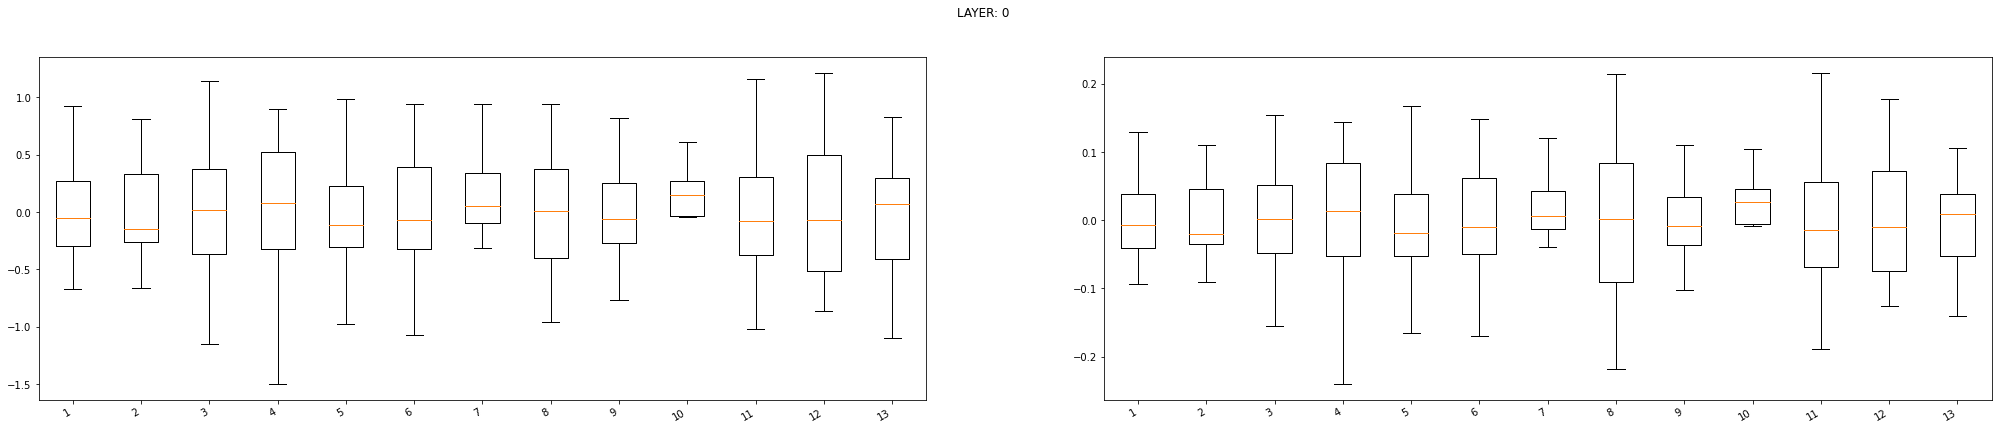

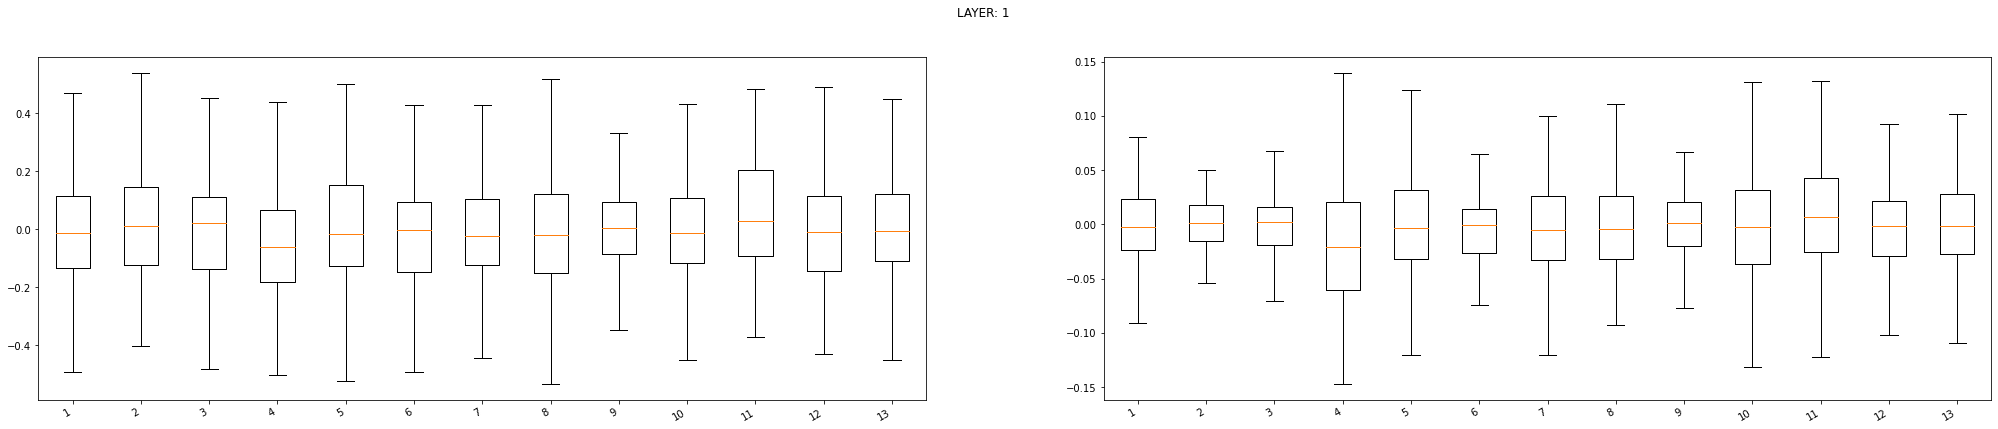

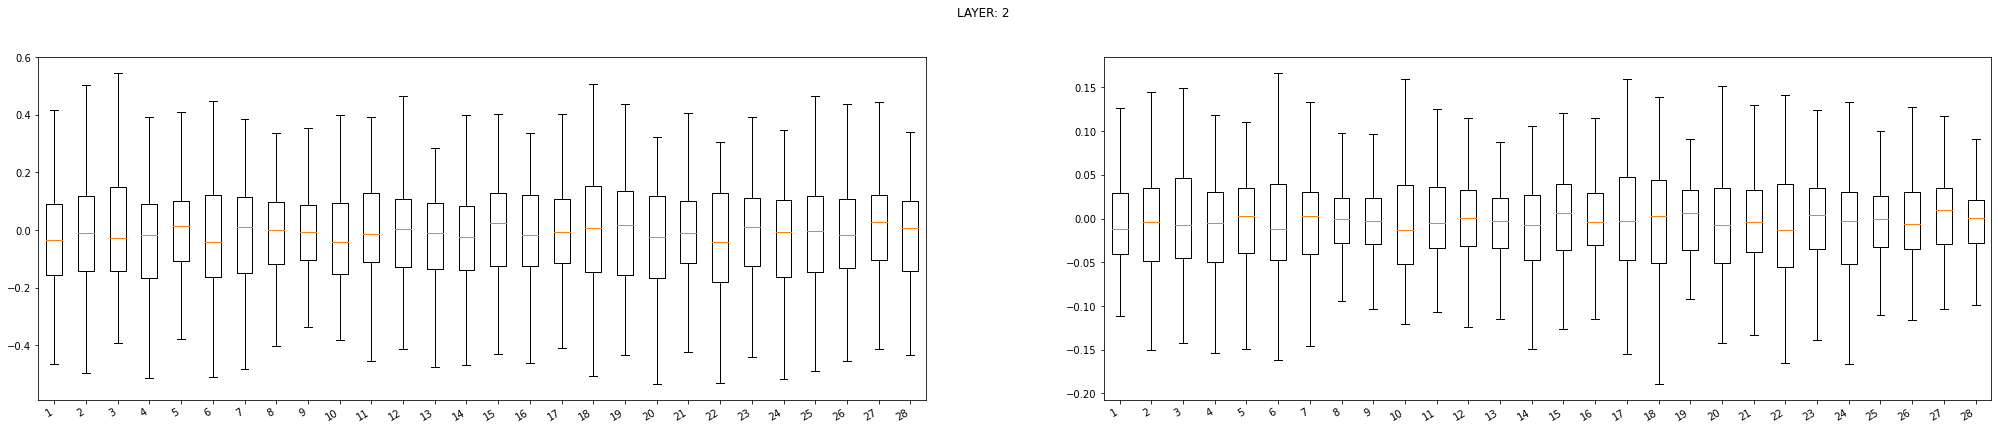

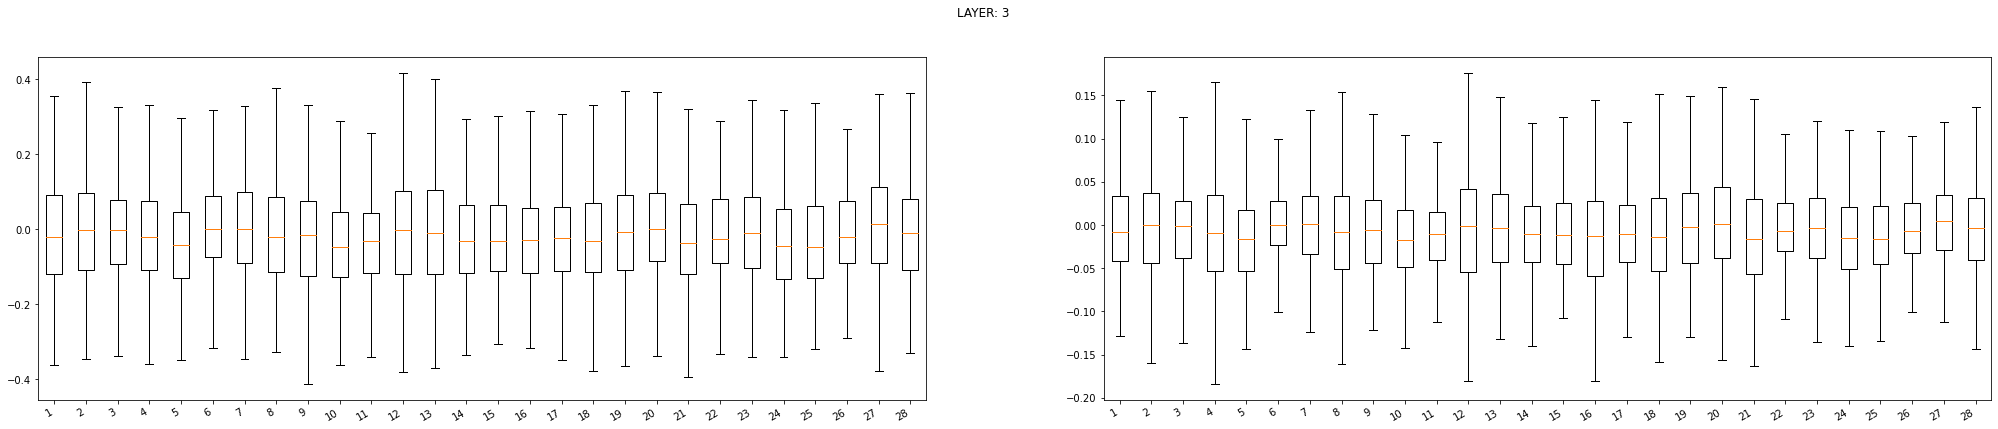

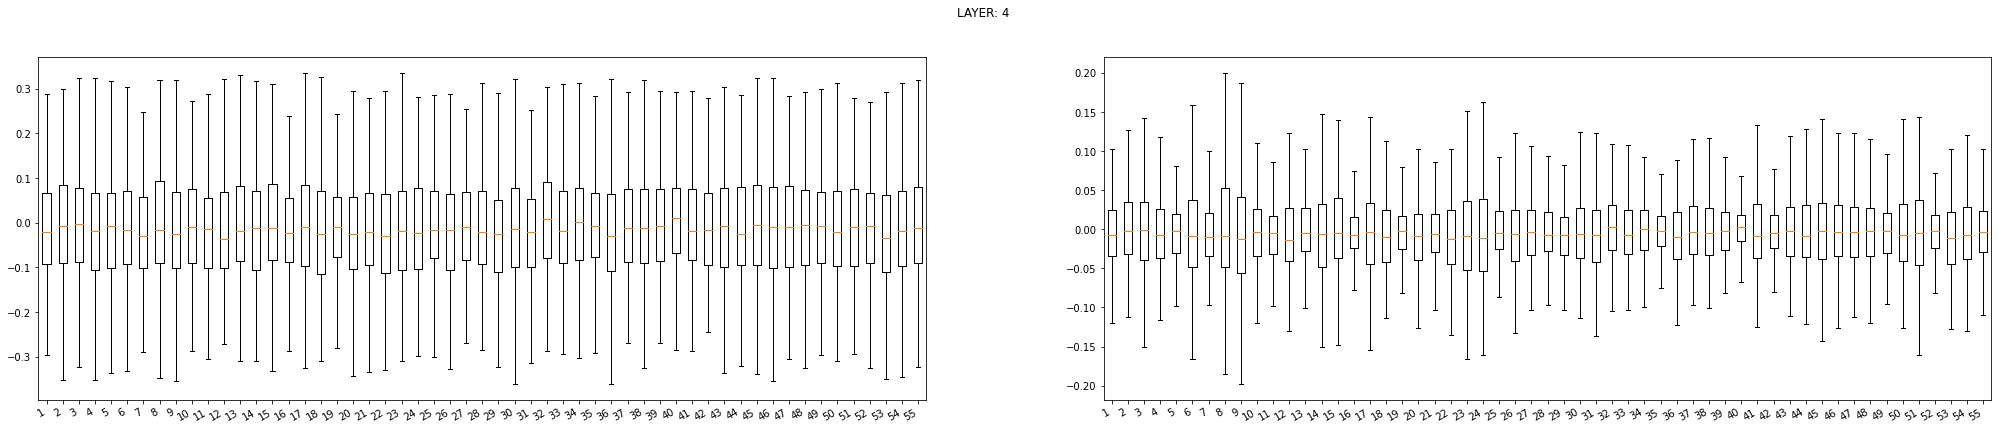

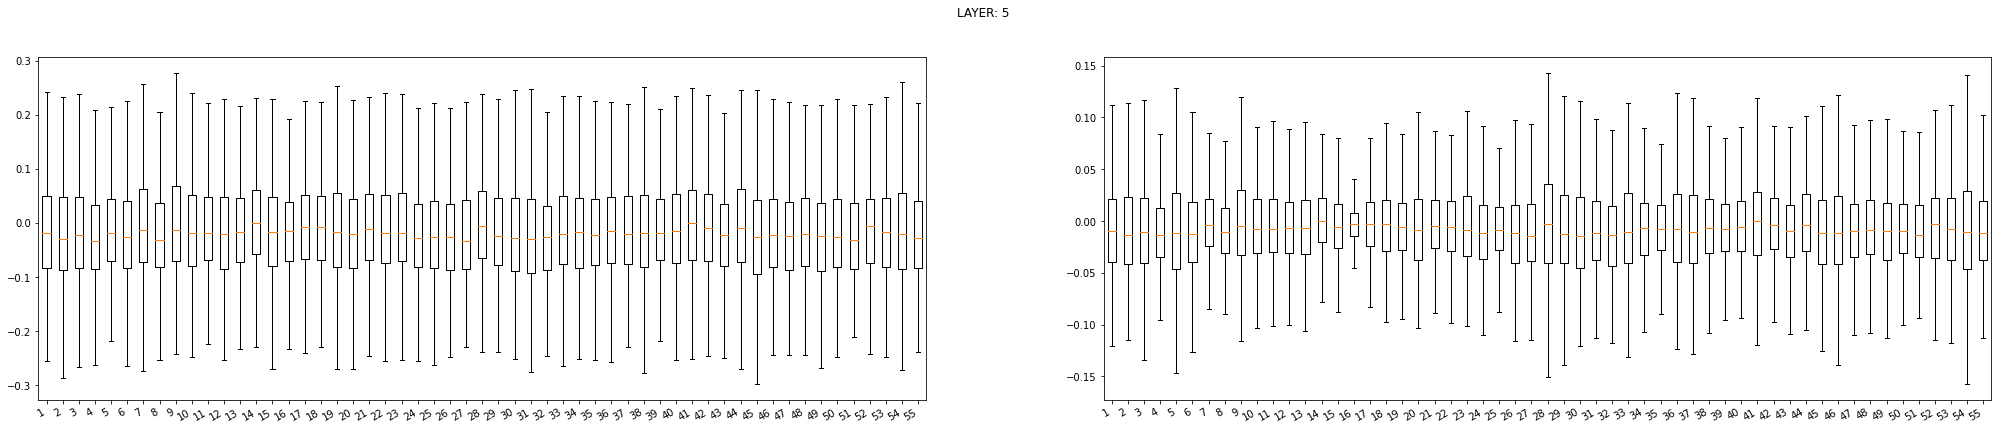

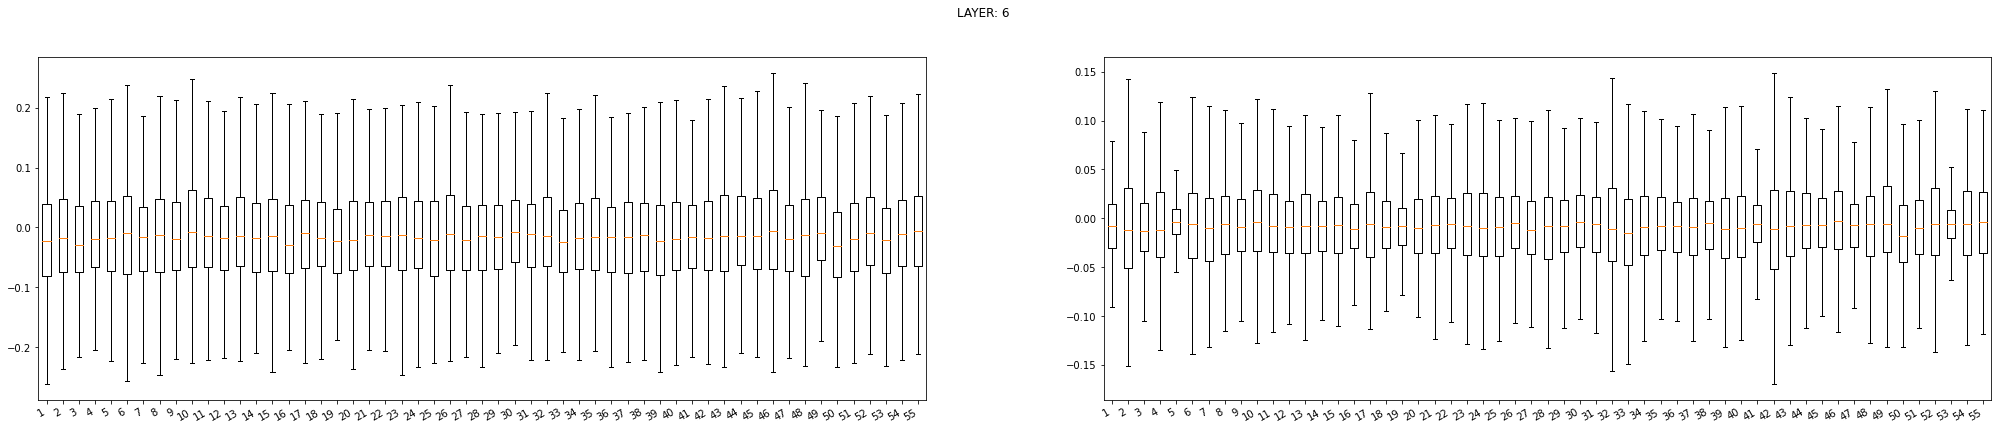

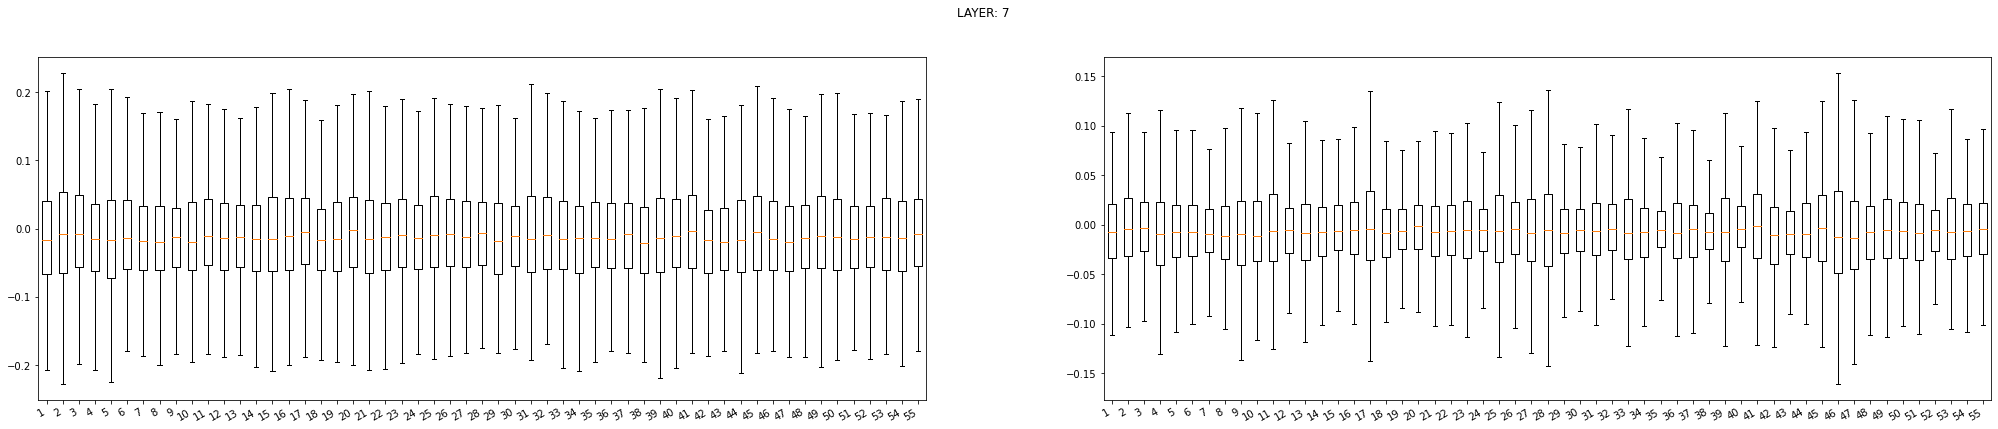

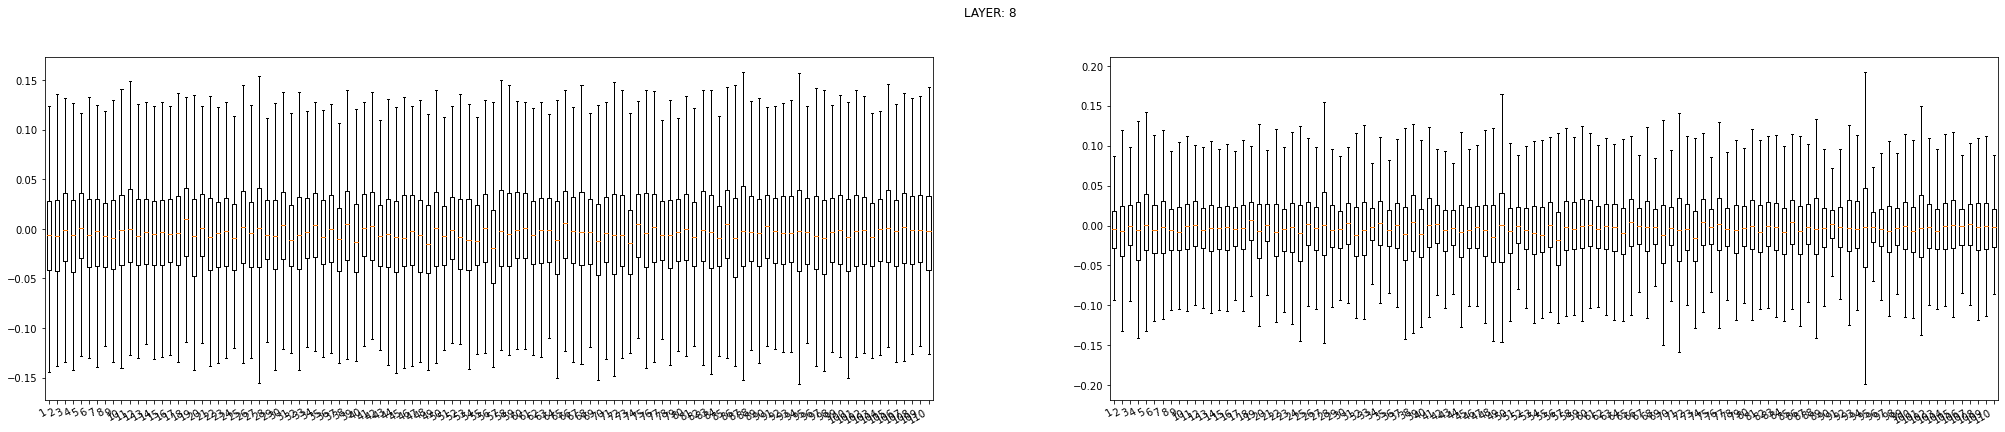

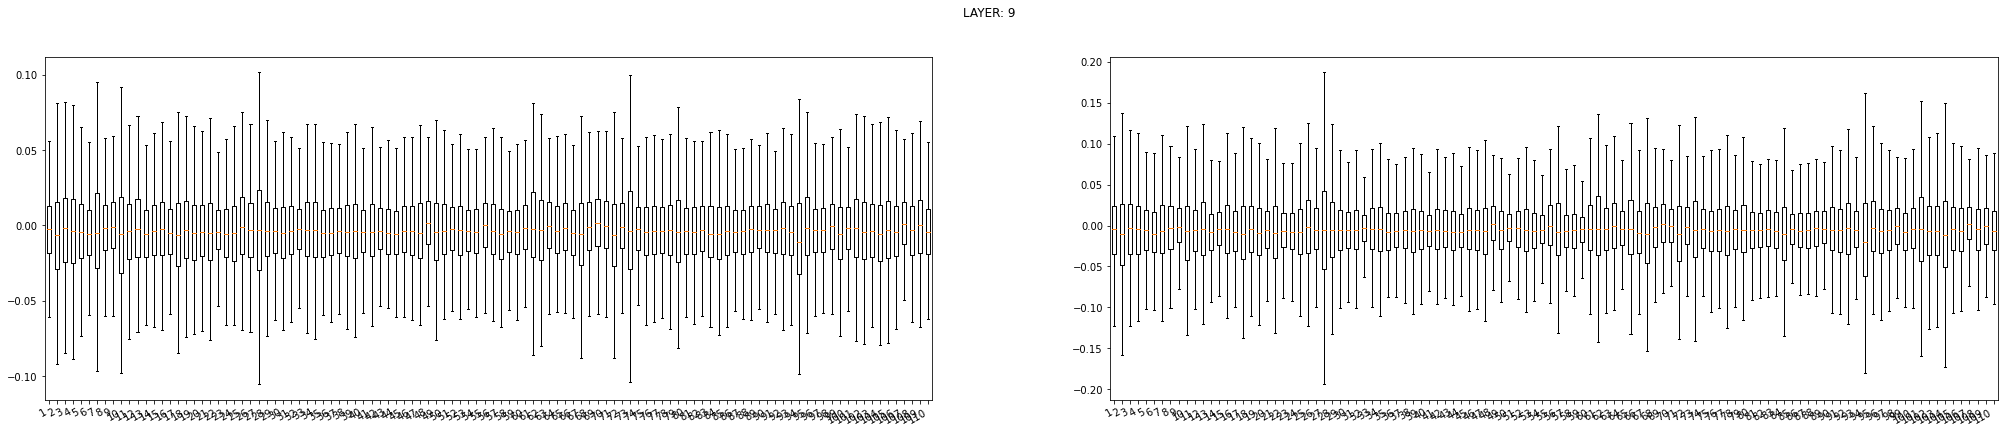

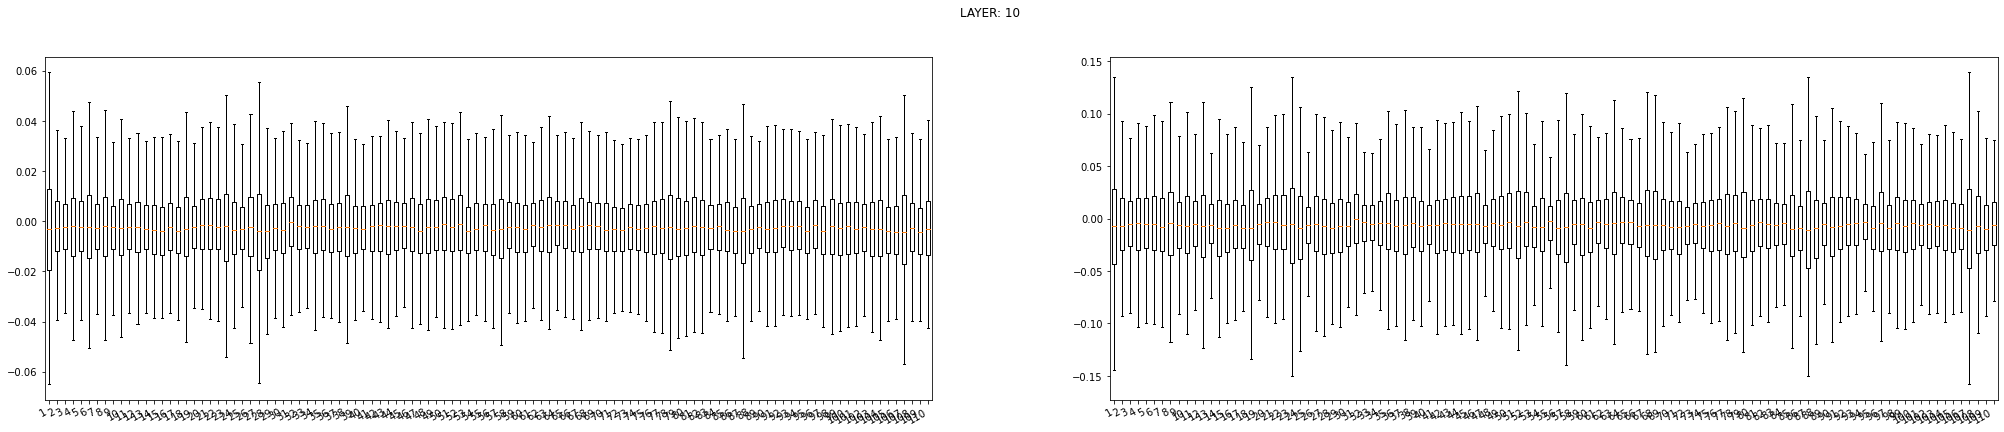

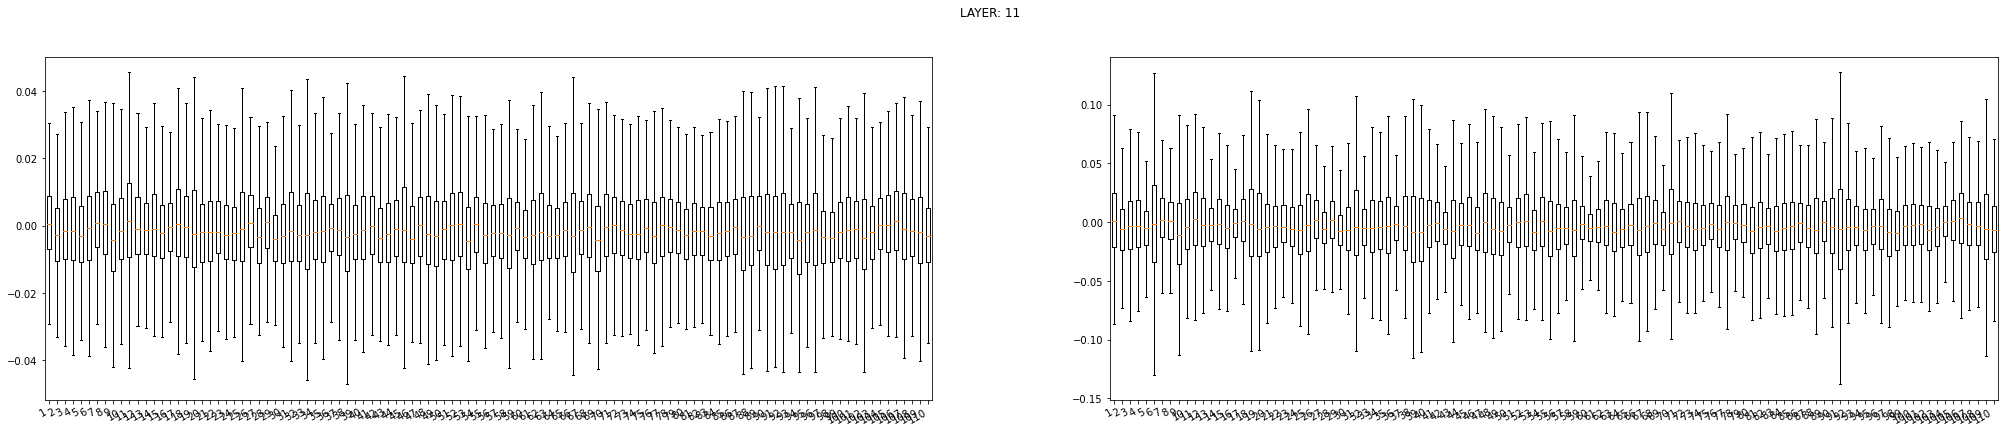

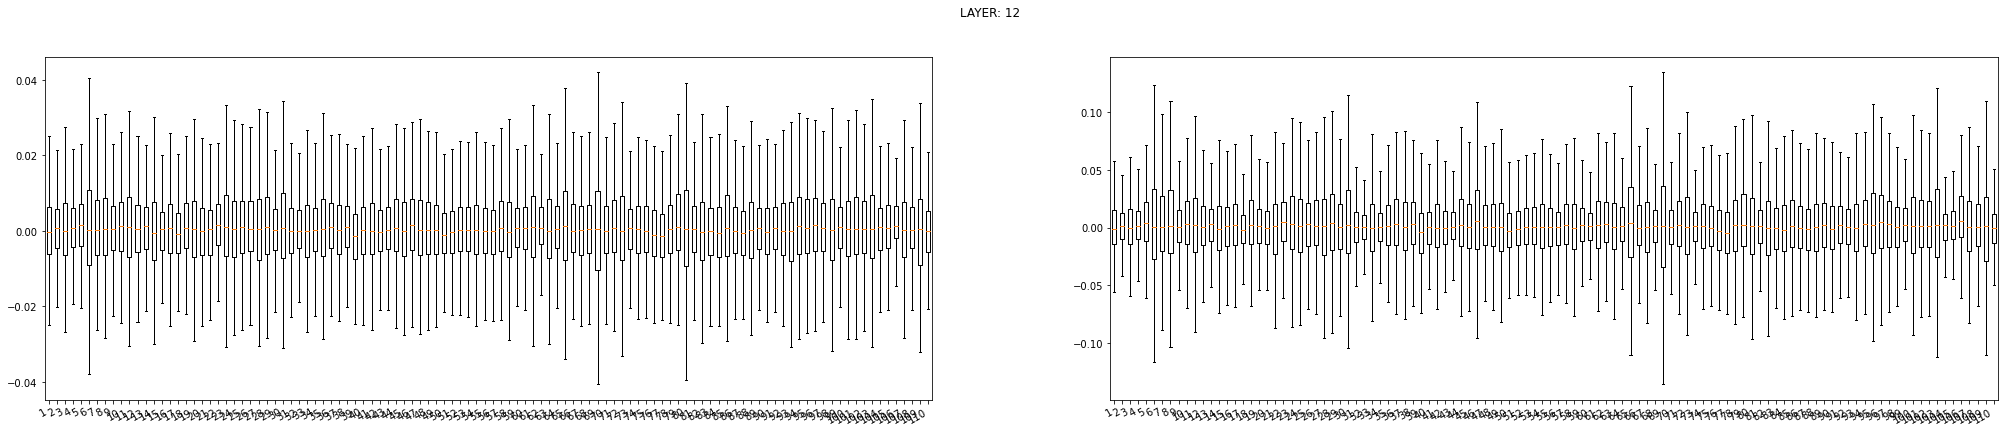

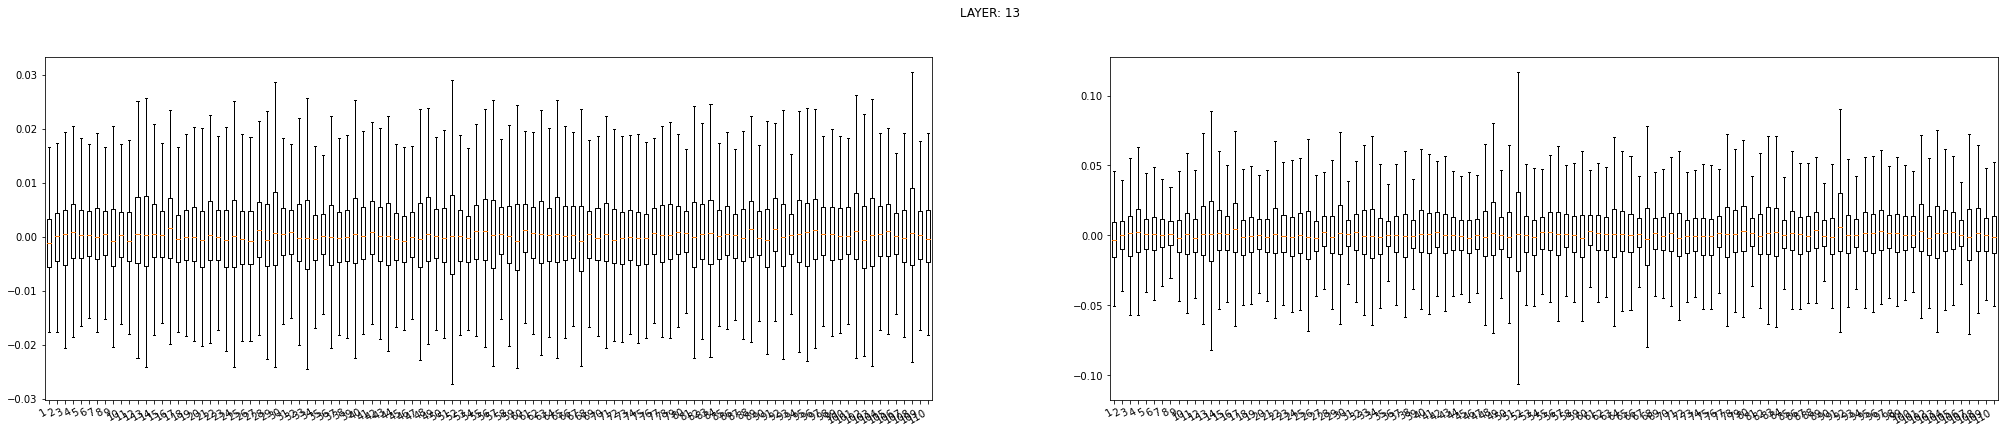

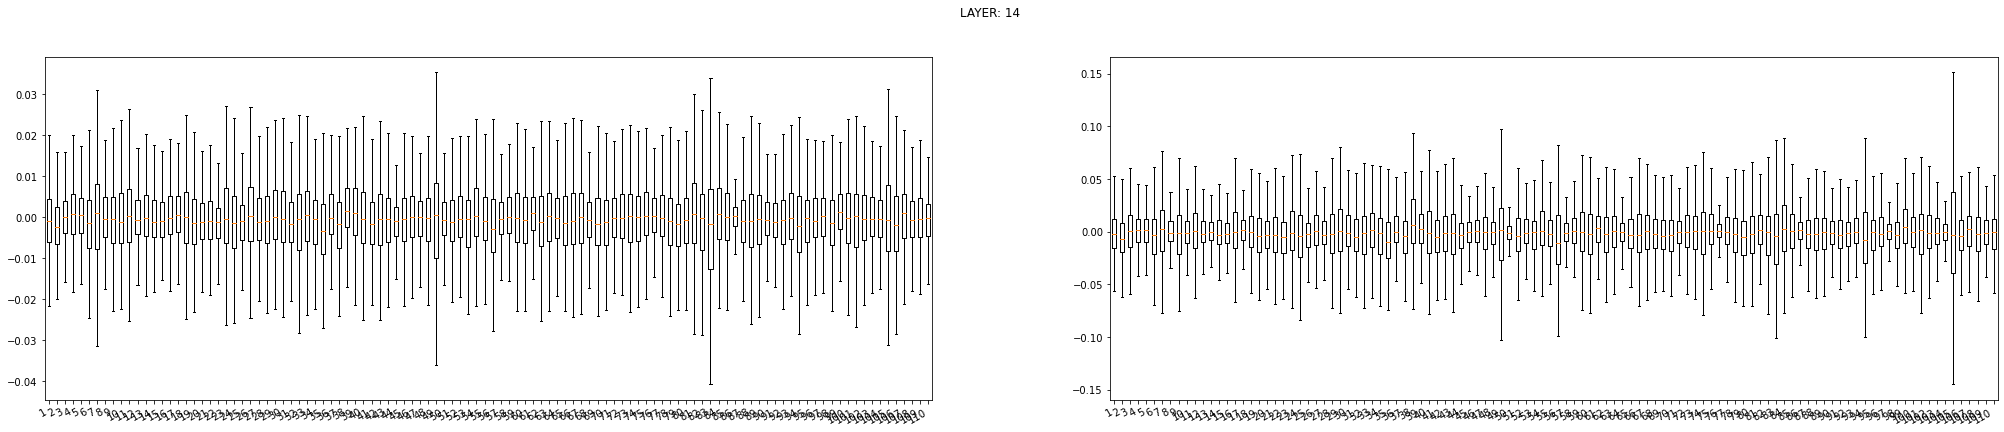

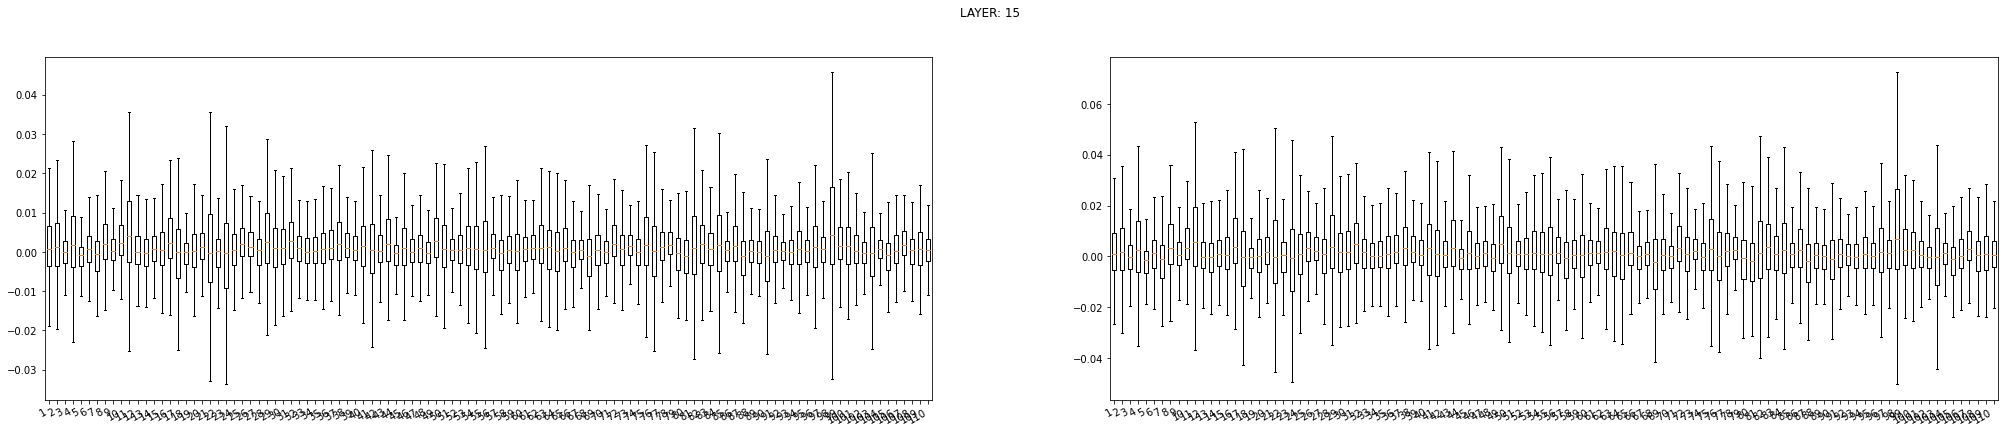

In [57]:

conv2d = [0,3,7,10,14,17,20,23,27,30,33,36,40,43,46,49]
plot_weights_VGG19(vgg19_small_model,conv2d,vgg19_small_fused_afcle,conv_list)

Quantizing model after AFCLE and recording stats (runtime, accuracy, size):

In [43]:
vgg19_smodel_afcle_quant = copy.deepcopy(vgg19_small_fused_afcle)
vgg19_smodel_afcle_quant = quantize_model(vgg19_smodel_afcle_quant)
rt_smodel_afcle_quant, acc_smodel_afcle_quant = validate_model(vgg19_smodel_afcle_quant, testloader,device="cpu")
print(acc_smodel_afcle_quant)

afcle_quant = []
afcle_quant.append(acc_smodel_afcle_quant.detach().numpy())
afcle_quant.append(round(rt_smodel_afcle_quant,3))
afcle_q_size = get_size_of_model(vgg19_smodel_afcle_quant)
afcle_quant.append(round(afcle_q_size,3))

[250] accuracy : 81.2000%
[500] accuracy : 81.7000%
[750] accuracy : 81.9333%
[1000] accuracy : 82.0000%
[1250] accuracy : 82.1000%
[1500] accuracy : 81.9833%
[1750] accuracy : 81.8143%
[2000] accuracy : 81.6125%
[2250] accuracy : 81.7444%
[2500] accuracy : 81.7000%
tensor(81.7000, dtype=torch.float64)
Model size:  1.010679


Plotting results:

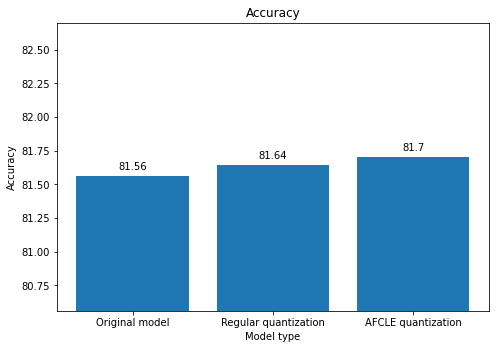

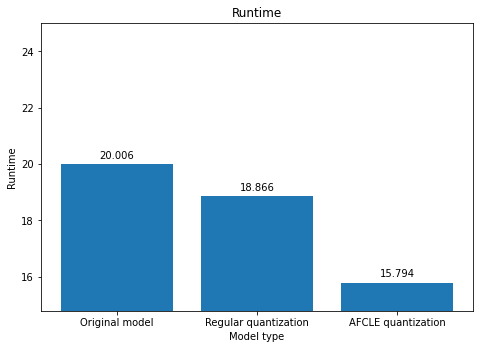

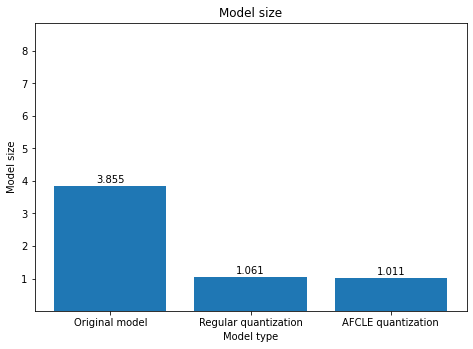

In [44]:
def addlabels(x,y,shift):
    for i in range(len(x)):
        plt.text(i, y[i]+shift, y[i], ha = 'center')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
m_type = ['Original model', 'Regular quantization', 'AFCLE quantization']
data = [original[0],normal_quant[0],afcle_quant[0]]
ax.bar(m_type,data)
addlabels(m_type,data,0.05)
max_y_lim = max(data) + 1
min_y_lim = min(data) - 1
plt.ylim(min_y_lim, max_y_lim)
plt.xlabel("Model type")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
m_type = ['Original model', 'Regular quantization', 'AFCLE quantization']
data = [original[1],normal_quant[1],afcle_quant[1]]
ax.bar(m_type,data)
addlabels(m_type,data,0.2)
max_y_lim = max(data) + 5
min_y_lim = min(data) - 1
plt.ylim(min_y_lim, max_y_lim)
plt.xlabel("Model type")
plt.ylabel("Runtime")
plt.title("Runtime")
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
m_type = ['Original model', 'Regular quantization', 'AFCLE quantization']
data = [original[2],normal_quant[2],afcle_quant[2]]
ax.bar(m_type,data)
addlabels(m_type,data,0.1)
max_y_lim = max(data) + 5
min_y_lim = min(data) - 1
plt.ylim(min_y_lim, max_y_lim)
plt.xlabel("Model type")
plt.ylabel("Model size")
plt.title("Model size")
plt.show()